# 4.1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch
from torch.utils.data import Subset
import matplotlib.gridspec as gridspec
import warnings


warnings.filterwarnings("ignore")


np.random.seed(42)
torch.manual_seed(42)

In [2]:
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean = None
        self.explained_variance = None
        self.explained_variance_ratio = None

    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean

        n_samples = X.shape[0]
        cov_matrix = np.dot(X_centered.T, X_centered) / (n_samples - 1)
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        self.components = eigenvectors[:, :self.n_components]

        self.explained_variance = eigenvalues[:self.n_components]
        total_variance = np.sum(eigenvalues)
        self.explained_variance_ratio = self.explained_variance / total_variance
        return self

    def transform(self, X):
        X_centered = X - self.mean
        X_transformed = np.dot(X_centered, self.components)
        return X_transformed

    def inverse_transform(self, X_transformed):
        X_reconstructed = np.dot(X_transformed, self.components.T) + self.mean
        return X_reconstructed

In [3]:
def load_mnist():
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    return train_dataset, test_dataset


def sample_uniform_distribution(dataset, num_samples=1000):
    samples_per_class = 100
    if hasattr(dataset, 'targets'):
        targets = dataset.targets
    else:
        targets = torch.tensor([dataset[i][1] for i in range(len(dataset))])

    if torch.is_tensor(targets):
        targets = targets.numpy()
    indices = []

    for class_idx in range(10):  # MNIST has 10 classes
        class_indices = np.where(targets == class_idx)[0]
        selected_indices = np.random.choice(class_indices, samples_per_class, replace=False)
        indices.extend(selected_indices)

    np.random.shuffle(indices)

    data = []
    labels = []

    for idx in indices:
        img, label = dataset[idx]
        # Flatten the image (28x28 -> 784)
        data.append(img.numpy().flatten())
        labels.append(label)

    return np.array(data), np.array(labels)

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.07MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.73MB/s]


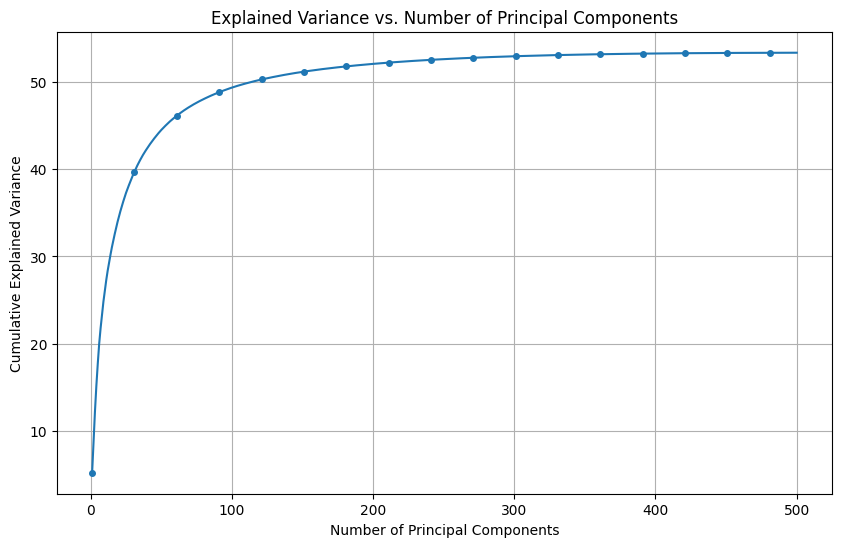

In [4]:

train_dataset, test_dataset = load_mnist()
X_sampled, y_sampled = sample_uniform_distribution(train_dataset, num_samples=1000)

dimensions = [500, 300, 150, 30]

pca_models = {}
X_transformed_all = {}
X_reconstructed_all = {}

pca_full = PCA(n_components=X_sampled.shape[1])
pca_full.fit(X_sampled)

for dim in dimensions:
    pca = PCA(n_components=dim)
    pca.fit(X_sampled)
    X_transformed = pca.transform(X_sampled)
    X_transformed_all[dim] = X_transformed
    X_reconstructed = pca.inverse_transform(X_transformed)
    X_reconstructed_all[dim] = X_reconstructed
    pca_models[dim] = pca

# Plot explained variance vs number of principal components
plt.figure(figsize=(10, 6))
cumulative_variance = np.cumsum(pca_full.explained_variance)
plot_components = min(500, len(cumulative_variance))

plt.plot(range(1, plot_components + 1), cumulative_variance[:plot_components], marker='o', linestyle='-', markersize=4,markevery=30)
plt.title('Explained Variance vs. Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()



plt.close()





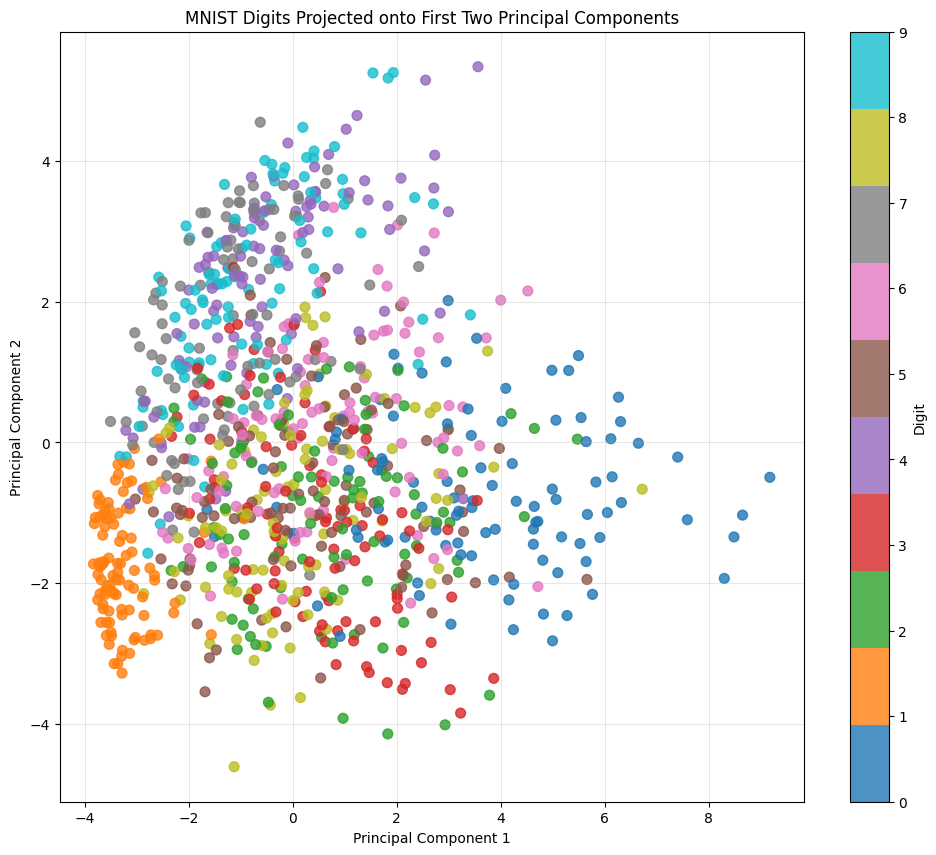

In [5]:
X_2d = X_transformed_all[dimensions[0]][:, :2]

plt.figure(figsize=(12, 10))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_sampled, cmap='tab10', s=50, alpha=0.8)
plt.colorbar(scatter, label='Digit')
plt.title('MNIST Digits Projected onto First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True, alpha=0.3)
plt.show()
plt.close()




# **Observations**


- The **distribution is highly overlapping**, indicating that the first two PCs alone are not sufficient to completely separate different digit classes.  
- Some digits, like **1 (orange), form clusters**, suggesting they are more distinguishable.  
- Digits **like 3, 5, and 8 (brown, pink, yellow) are more scattered**, indicating higher intra-class variance.  


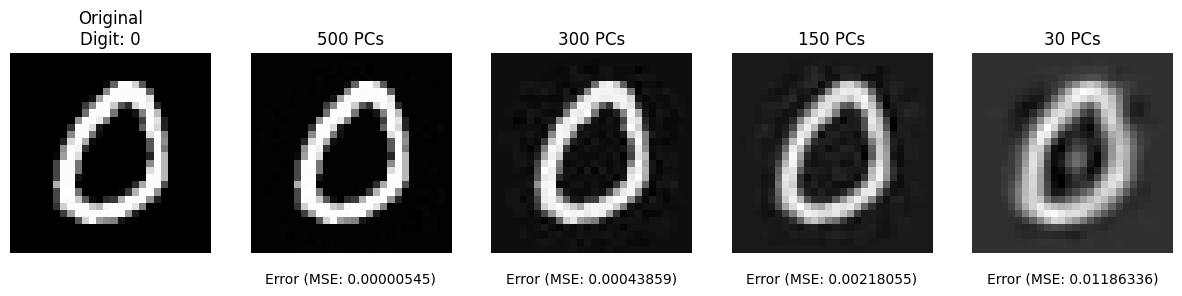

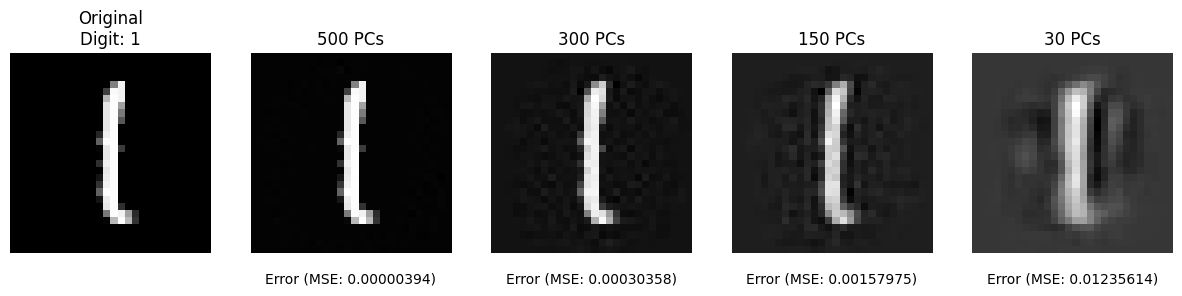

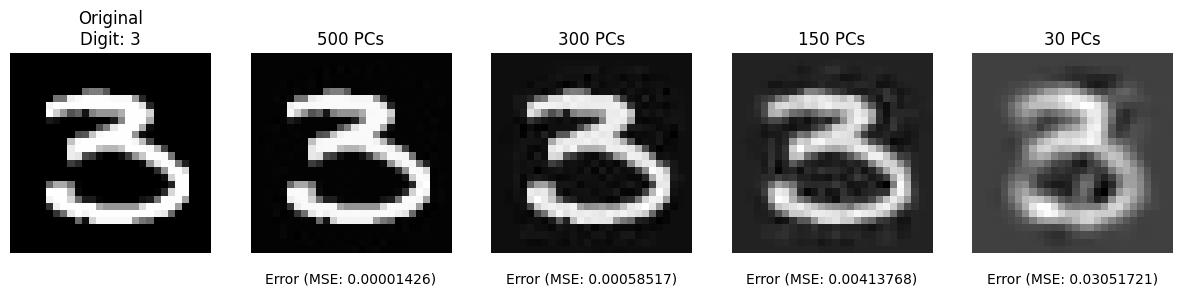

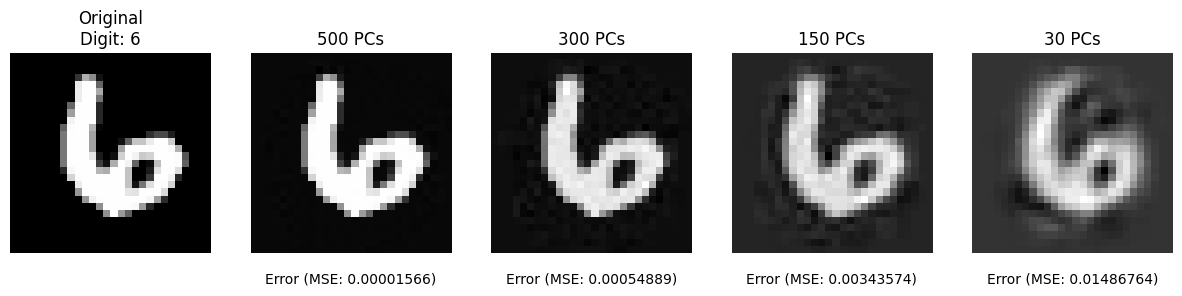

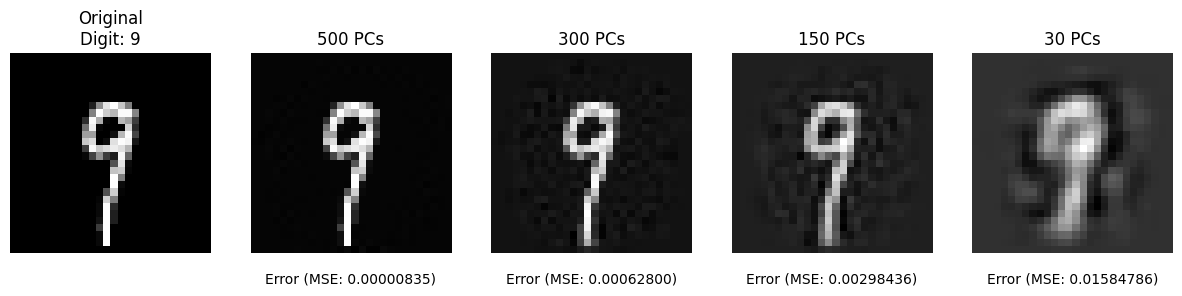

In [6]:
selected_digits = [0, 1, 3, 6, 9]
selected_indices = []

for digit in selected_digits:
    digit_indices = np.where(y_sampled == digit)[0]
    if len(digit_indices) > 0:
        selected_indices.append(digit_indices[0])


# Visualization of original and reconstructed images
for idx in selected_indices:
    fig = plt.figure(figsize=(15, 10))
    gs = gridspec.GridSpec(2, len(dimensions) + 1)

    # Original image
    ax = plt.subplot(gs[0, 0])
    original_image = X_sampled[idx].reshape(28, 28)
    ax.imshow(original_image, cmap='gray')
    ax.set_title(f"Original\nDigit: {y_sampled[idx]}")
    ax.axis('off')

    # Reconstructed images for each dimension
    for i, dim in enumerate(dimensions):
        ax = plt.subplot(gs[0, i+1])
        reconstructed = X_reconstructed_all[dim][idx].reshape(28, 28)
        mse = np.mean((original_image - reconstructed) ** 2)
        ax.imshow(reconstructed, cmap='gray')
        ax.set_title(f"{dim} PCs")
        ax.text(0.5, -0.15, f"Error (MSE: {mse:.8f})", fontsize=10, ha='center', transform=ax.transAxes)
        ax.axis('off')

    plt.show()
    plt.close()

# **Observations on PCA Reconstruction**

- **500 PCs:** The reconstructed image is almost identical to the original, with minimal loss of detail .  
- **300 PCs:** Slight blurring is visible, but the digit remains sharp and well-defined .  
- **150 PCs:** The digit starts losing finer details, and noise appears in the background .  
- **30 PCs:** The digit becomes significantly blurry, losing important features and appearing distorted .  

Higher PCs retain more details, while fewer PCs lead to more distortion and loss of information.  


# 4.2

In [7]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
import time
from sklearn.preprocessing import StandardScaler


In [8]:
def prepare_data(train_dataset, test_dataset, train_samples=40000):
    # Sample random 40K from training set
    train_indices = np.random.choice(len(train_dataset), train_samples, replace=False)
    X_train = []
    y_train = []
    for idx in train_indices:
        img, label = train_dataset[idx]
        X_train.append(img.numpy().flatten())
        y_train.append(label)
    X_test = []
    y_test = []
    for i in range(len(test_dataset)):
        img, label = test_dataset[i]
        X_test.append(img.numpy().flatten())
        y_test.append(label)

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

def train_and_evaluate_mlp(X_train, y_train, X_test, y_test, hidden_layer_sizes):
    mlp = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation='relu',
        solver='adam',
        alpha=0.0001,
        max_iter=100,
        random_state=42,
    )

    mlp.fit(X_train, y_train)
    y_pred = mlp.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'model': mlp
    }

In [9]:


train_dataset, test_dataset = load_mnist()
X_train, y_train, X_test, y_test = prepare_data(train_dataset, test_dataset, train_samples=40000)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
original_results = train_and_evaluate_mlp(X_train_scaled, y_train, X_test_scaled, y_test, hidden_layer_sizes=(256,128))

print("\nResults on original data:")
print(f"Accuracy: {original_results['accuracy']:.8f}")
print(f"Precision: {original_results['precision']:.8f}")
print(f"Recall: {original_results['recall']:.8f}")



dimensions = [500, 300, 150, 30]
pca_results = {}

for dim in dimensions:
    print(f"\nPerforming PCA with {dim} components...")

    pca = PCA(n_components=dim)
    pca.fit(X_train_scaled)
    X_train_pca = pca.transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    print(f"Training MLP on {dim}-dimensional data...")
    results = train_and_evaluate_mlp(X_train_pca, y_train, X_test_pca, y_test, hidden_layer_sizes=(256,128))
    pca_results[dim] = results

    print(f"\nResults with {dim} components:")
    print(f"Accuracy: {results['accuracy']:.8f}")
    print(f"Precision: {results['precision']:.8f}")
    print(f"Recall: {results['recall']:.8f}")
    print("\n\n")

metrics = ['accuracy', 'precision', 'recall']





Results on original data:
Accuracy: 0.97640000
Precision: 0.97641492
Recall: 0.97640000

Performing PCA with 500 components...
Training MLP on 500-dimensional data...

Results with 500 components:
Accuracy: 0.97030000
Precision: 0.97034299
Recall: 0.97030000




Performing PCA with 300 components...
Training MLP on 300-dimensional data...

Results with 300 components:
Accuracy: 0.97230000
Precision: 0.97231544
Recall: 0.97230000




Performing PCA with 150 components...
Training MLP on 150-dimensional data...

Results with 150 components:
Accuracy: 0.97500000
Precision: 0.97502357
Recall: 0.97500000




Performing PCA with 30 components...
Training MLP on 30-dimensional data...

Results with 30 components:
Accuracy: 0.96400000
Precision: 0.96415057
Recall: 0.96400000





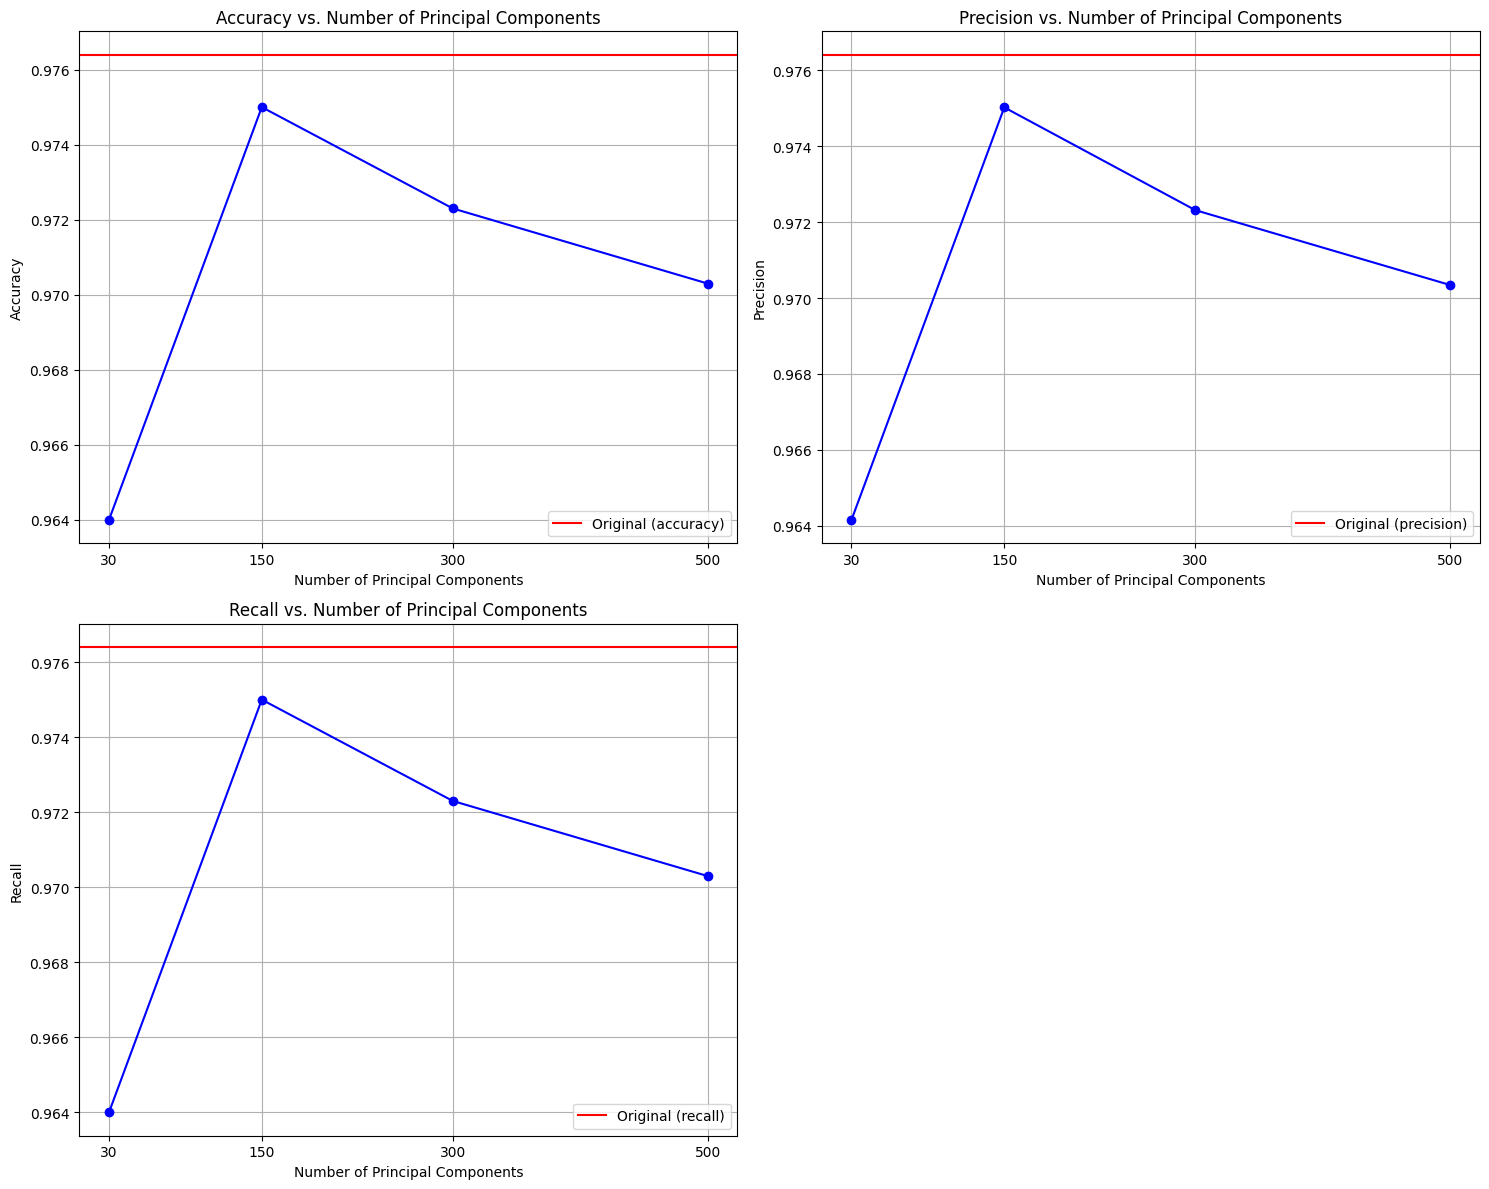

In [10]:
plt.figure(figsize=(15, 12))
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    plt.axhline(y=original_results[metric], color='r', linestyle='-', label=f'Original ({metric})')
    values = [pca_results[dim][metric] for dim in dimensions]
    plt.plot(dimensions, values, marker='o', linestyle='-', color='b')
    plt.title(f'{metric.capitalize()} vs. Number of Principal Components')
    plt.xlabel('Number of Principal Components')
    plt.ylabel(metric.capitalize())
    plt.xticks(dimensions)
    plt.grid(True)
    plt.legend()


plt.tight_layout()
plt.show()
plt.close()

### **Observations on PCA and MLP Performance**

1. **Effect of Dimensionality Reduction**  
   - Reducing dimensions using PCA affects the classification performance of the MLP model.  

2. **Performance at 30 Components**  
   - Accuracy, precision, and recall are lowest when using only 30 principal components.  

3. **Optimal Performance at 150 Components**  
   - All metrics peak at 150 components, indicating a good balance between compression and retention of information.  

4. **Performance Decline Beyond 150 Components**  
   - Increasing components to 300 and 500 results in a slight decline in performance.  

5. **Comparison with Baseline (No PCA)**  
   - The original model (without PCA) performs slightly better, suggesting some information loss due to dimensionality reduction.  


# Report

### **PCA and the Curse of Dimensionality**
1. **Mitigation of the Curse of Dimensionality**  
   - PCA reduces the number of dimensions while retaining essential information, thereby improving computational efficiency and reducing overfitting.  
   - It removes redundant and less informative features, leading to better generalization in machine learning models.  
   - Lower-dimensional representations require fewer training samples to achieve good performance.  

2. **When PCA Might Not Be Effective**  
   - If the dataset has **non-linear relationships**, PCA (a linear transformation) may fail to capture crucial patterns.  
   - In cases where **all features are equally important**, reducing dimensions can lead to information loss.  

### **Limitations of PCA's Assumption on Variance**  
1. **Not Always True**  
   - PCA assumes that the most informative features correspond to the **directions of maximum variance**. However, this is not always the case.  

2. **Failure Case Example**  
   - Consider a **classification problem with two overlapping Gaussian distributions**. The direction of **maximum variance** may not align with the feature that best separates the classes.  
   - In **anomaly detection**, rare but crucial variations might have low variance and get discarded by PCA.   
